In [22]:
%matplotlib inline
import pandas as pd  
import numpy as np

from sklearn.cross_validation import train_test_split  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import precision_recall_curve  
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import bisect  
from scipy.stats import mstats

In [2]:
df = pd.read_csv('http://www.dataminingconsultant.com/data/churn.txt')

In [3]:
# Some Preprocessing
df.columns = [c.lower().replace(' ', '_').replace('?', '').replace("'", "") for c in df.columns]

In [4]:
state_encoder = LabelEncoder()  
df.state = state_encoder.fit_transform(df.state)

del df['phone']

In [5]:
binary_columns = ['intl_plan', 'vmail_plan', 'churn']  
for col in binary_columns:  
    df[col] = df[col].map({
            'no': 0
        ,   'False.': 0
        ,   'yes': 1
        ,   'True.': 1
    })


In [6]:
# Build the classifier and get the predictions
clf = RandomForestClassifier(n_estimators=50, oob_score=True)  
test_size_percent = 0.1

signals = df[[c for c in df.columns if c != 'churn']]  
labels = df['churn']

In [16]:
train_signals, test_signals, train_labels, test_labels = train_test_split(signals, labels, test_size=test_size_percent)  
clf.fit(train_signals, train_labels)  
predictions = clf.predict_proba(test_signals)[:,1]

In [8]:
precision, recall, thresholds = precision_recall_curve(test_labels, predictions)  
thresholds = np.append(thresholds, 1)

queue_rate = []  
for threshold in thresholds:  
    queue_rate.append((predictions >= threshold).mean())

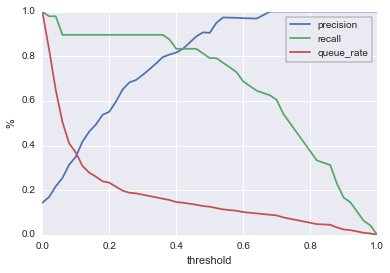

In [10]:
plt.plot(thresholds, precision, color=sns.color_palette()[0])  
plt.plot(thresholds, recall, color=sns.color_palette()[1])  
plt.plot(thresholds, queue_rate, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')

plt.show()

In [11]:
clf = RandomForestClassifier(n_estimators=50, oob_score=True)

In [13]:
n_trials = 50  
test_size_percent = 0.1

signals = df[[c for c in df.columns if c != 'churn']]  
labels = df['churn']

plot_data = []

In [18]:
for trial in range(n_trials):  
    train_signals, test_signals, train_labels, test_labels = train_test_split(signals, labels, test_size=test_size_percent)
    clf.fit(train_signals, train_labels)
    predictions = clf.predict_proba(test_signals)[:,1]

    precision, recall, thresholds = precision_recall_curve(test_labels, predictions)
    thresholds = np.append(thresholds, 1)

    queue_rate = []
    for threshold in thresholds:
        queue_rate.append((predictions >= threshold).mean())

In [19]:
    plot_data.append({
            'thresholds': thresholds
        ,   'precision': precision
        ,   'recall': recall
        ,   'queue_rate': queue_rate
    })

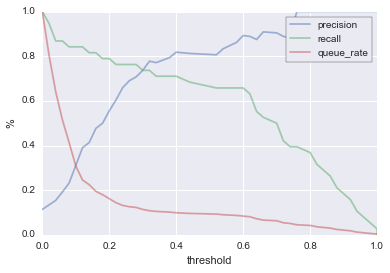

In [21]:
for p in plot_data:  
    plt.plot(p['thresholds'], p['precision'], color=sns.color_palette()[0], alpha=0.5)
    plt.plot(p['thresholds'], p['recall'], color=sns.color_palette()[1], alpha=0.5)
    plt.plot(p['thresholds'], p['queue_rate'], color=sns.color_palette()[2], alpha=0.5)

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')  
plt.show()

In [23]:
uniform_thresholds = np.linspace(0, 1, 101)

uniform_precision_plots = []  
uniform_recall_plots= []  
uniform_queue_rate_plots= []


In [24]:
for p in plot_data:  
    uniform_precision = []
    uniform_recall = []
    uniform_queue_rate = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        uniform_precision.append(p['precision'][index])
        uniform_recall.append(p['recall'][index])
        uniform_queue_rate.append(p['queue_rate'][index])

    uniform_precision_plots.append(uniform_precision)
    uniform_recall_plots.append(uniform_recall)
    uniform_queue_rate_plots.append(uniform_queue_rate)

In [25]:
quantiles = [0.1, 0.5, 0.9]  
lower_precision, median_precision, upper_precision = mstats.mquantiles(uniform_precision_plots, quantiles, axis=0)  
lower_recall, median_recall, upper_recall = mstats.mquantiles(uniform_recall_plots, quantiles, axis=0)  
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(uniform_queue_rate_plots, quantiles, axis=0)

/Users/jdursun/.virtualenvs/lovely/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


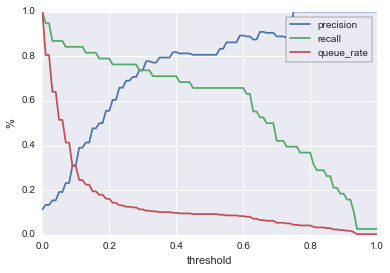

In [26]:
plt.plot(uniform_thresholds, median_precision)  
plt.plot(uniform_thresholds, median_recall)  
plt.plot(uniform_thresholds, median_queue_rate)

plt.fill_between(uniform_thresholds, upper_precision, lower_precision, alpha=0.5, linewidth=0, color=sns.color_palette()[0])  
plt.fill_between(uniform_thresholds, upper_recall, lower_recall, alpha=0.5, linewidth=0, color=sns.color_palette()[1])  
plt.fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate, alpha=0.5, linewidth=0, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')  
plt.show()

/Users/jdursun/.virtualenvs/lovely/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


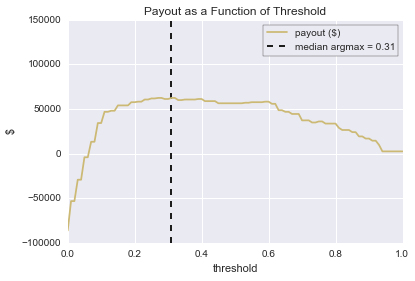

In [27]:
uniform_thresholds = np.linspace(0, 1, 101)

uniform_payout_plots = []

n = 10000  
success_payoff = 100  
case_cost = 20

for p in plot_data:  
    uniform_payout = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        precision = p['precision'][index]
        queue_rate = p['queue_rate'][index]

        payout = n*queue_rate*(precision*100 - case_cost)
        uniform_payout.append(payout)

    uniform_payout_plots.append(uniform_payout)

quantiles = [0.1, 0.5, 0.9]  
lower_payout, median_payout, upper_payout = mstats.mquantiles(uniform_payout_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_payout, color=sns.color_palette()[4])  
plt.fill_between(uniform_thresholds, upper_payout, lower_payout, alpha=0.5, linewidth=0, color=sns.color_palette()[4])

max_ap = uniform_thresholds[np.argmax(median_payout)]  
plt.vlines([max_ap], -100000, 150000, linestyles='--')  
plt.ylim(-100000, 150000)

leg = plt.legend(('payout ($)', 'median argmax = {:.2f}'.format(max_ap)), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('$')  
plt.title("Payout as a Function of Threshold")  
plt.show()